<a href="https://colab.research.google.com/github/hamzafarooq/pycaret/blob/master/TimeSeries_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print(tf.__version__)
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import imageio
import os
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt


2.3.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Read Data


In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')



Authenticated


In [ ]:
%%bigquery --project bold-sorter-281506 df2
SELECT *
FROM `bigquery-public-data.iowa_liquor_sales.sales`
where store_number  = '2633'
and date > '2018-01-01'

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#drive.flush_and_unmount()

In [ ]:
import pandas as pd

url = 'https://drive.google.com/file/d/1Pm_WoZZa9JKDpZDqVLGBetIiiFb61NL2/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)

In [ ]:
path

'https://drive.google.com/uc?export=download&id=1Pm_WoZZa9JKDpZDqVLGBetIiiFb61NL2'

In [ ]:
len(df)

286230

In [ ]:
len(df2)

50527

In [ ]:
df2.head(5)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-19309700006,2019-05-13,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1012300,Single Malt Scotch,266,Edrington Group USA LLC,5486,Macallan 12 Yr Single Malt Scotch,12,750,34.99,52.49,84,4409.16,63.0,16.64
1,INV-15347200002,2018-10-29,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1011600,Straight Rye Whiskies,214,GoAmericaGo Beverages LLC,27145,WhistlePig Old World 12YR,6,750,64.17,96.26,30,2887.80,22.5,5.94
2,INV-11117400006,2018-03-26,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1901200,Special Order Items,459,SURVILLE ENTERPRISES CORP,904955,1921 Tequila Reposado,6,750,26.50,39.75,12,477.00,9.0,2.38
3,INV-10206700012,2018-02-05,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1012300,Single Malt Scotch,266,Edrington Group USA LLC,5486,Macallan 12 Yr Single Malt Scotch,12,750,34.99,52.49,12,566.88,9.0,2.38
4,INV-11743500040,2018-04-26,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1011600,Straight Rye Whiskies,306,MISSISSIPPI RIVER DISTIL,27027,Cody Road Rye,6,750,19.17,28.76,6,172.56,4.5,1.19


In [ ]:
df2_ds = df2[['date','sale_dollars']]


In [ ]:
df2_ds=df2_ds.sort_index(axis=0)

In [ ]:
df2_ds.tail(5)

,date,sale_dollars
50522,2019-12-09,1379.88
50523,2019-11-25,148.50
50524,2019-10-24,119.28
50525,2019-10-17,119.28
50526,2019-10-21,279.00


In [ ]:
aggregated=df2_ds.groupby('date',as_index=True).sum()

In [ ]:
aggregated.tail(5)

,sale_dollars
date,
2020-07-21,22054.44
2020-07-23,79001.99
2020-07-27,59207.67
2020-07-28,1905.24
2020-07-30,117104.75


In [ ]:
aggregated.index=pd.to_datetime(aggregated.index)

#Create Fetaures

In [ ]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['flag'] = pd.Series(np.where(df['date'] >= np.datetime64('2020-03-03'), 1, 0), index=df.index)
    #df['rolling_mean_7'] = df['sale_dollars'].shift(7).rolling(window=7).mean()
    #df['lag_7'] = df['sale_dollars'].shift(7)
    #df['lag_15']=df['sale_dollars'].shift(15)
    #df['lag_last_year']=df['sale_dollars'].shift(52).rolling(window=15).mean()
  
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','flag','sale_dollars']]
    X.index=df.index
    return X

In [ ]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

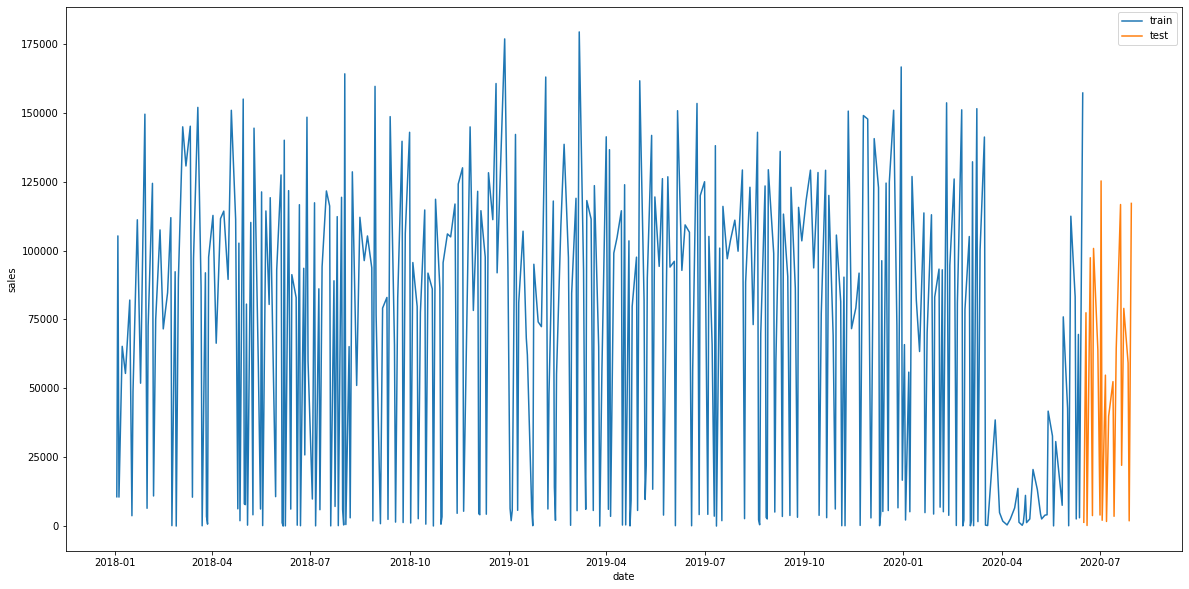

In [ ]:
aggregated=create_features(aggregated)
train, test = split_data(aggregated, '2020-06-15')

plt.figure(figsize=(20,10))
plt.xlabel('date')
plt.ylabel('sales')
plt.plot(train.index,train['sale_dollars'],label='train')
plt.plot(test.index,test['sale_dollars'],label='test')
plt.legend()
plt.show()


In [ ]:
train.tail(4)

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,flag,sale_dollars
date,,,,,,,,,
2020-06-09,1,2,6,2020,161,9,24,1,2588.94
2020-06-11,3,2,6,2020,163,11,24,1,69550.07
2020-06-12,4,2,6,2020,164,12,24,1,3011.43
2020-06-15,0,2,6,2020,167,15,25,1,157158.24


# Run PyCaret

In [ ]:
#!pip install pycaret

In [ ]:
from pycaret.regression import *

In [ ]:
reg = setup(data = train, 
             target = 'sale_dollars',
             numeric_imputation = 'mean',
             categorical_features = ['dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear',
                                     'flag']  , transformation = True, transform_target = True, 
                  combine_rare_levels = True, rare_level_threshold = 0.1,
                  remove_multicollinearity = True, multicollinearity_threshold = 0.95, 
             silent = True)

 
Setup Succesfully Completed.


,Description,Value
0,session_id,3317
1,Transform Target,True
2,Transform Target Method,yeo-johnson
3,Original Data,"(385, 9)"
4,Missing Values,False
5,Numeric Features,0
6,Categorical Features,8
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [ ]:
# return best model
top3 = compare_models(n_select = 3)

In [ ]:
lightgbm = create_model('lightgbm')

In [ ]:
#%tb
tuned_lightgbm = tune_model(lightgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,14431.5593,542576247.5950,23293.2661,0.8466,1.4587,7.3101
1,20931.0364,918847465.7815,30312.4969,0.6445,0.8542,0.9890
2,23037.8635,1275747099.5163,35717.6021,0.5974,1.7299,36.5634
3,19180.5552,710380780.8072,26652.9695,0.7355,0.9731,2.2753
4,15460.4295,463228851.6735,21522.7520,0.8259,2.6065,23.8429
5,23369.2141,1443009406.4972,37986.9636,0.5812,1.5001,6.5738
6,35430.6882,2116771223.0357,46008.3821,0.1802,1.0167,1.6703
7,19276.4039,1201504518.8925,34662.7252,0.5679,1.6204,13.3848
8,17615.2131,625084715.7877,25001.6943,0.7722,1.1948,3.0336
9,25151.1226,1383153818.0777,37190.7760,0.5597,1.4616,5.4326


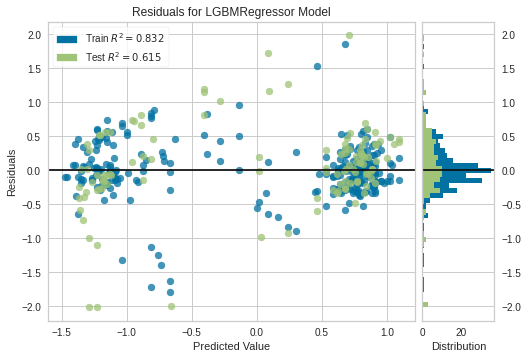

In [ ]:
plot_model(lightgbm)

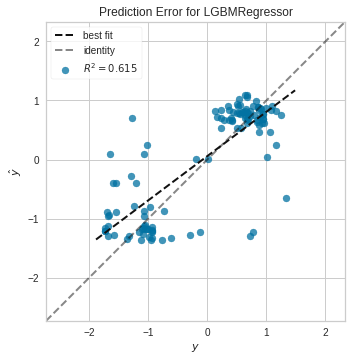

In [ ]:
plot_model(lightgbm, plot = 'error')

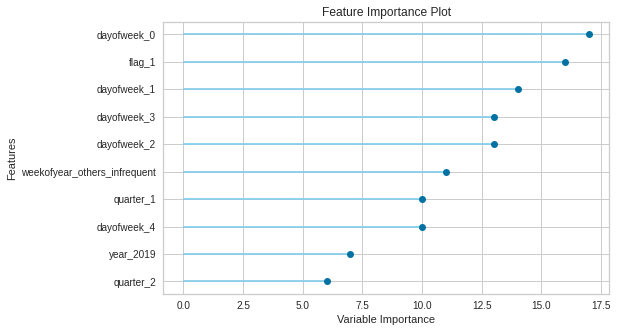

In [ ]:
plot_model(tuned_lightgbm, plot='feature')

In [ ]:
predict_model(tuned_lightgbm);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,21754.7213,1.149871e+09,33909.7528,0.5568,1.6057,0 8.588966 dtype: float64


In [ ]:
final_lightgbm = finalize_model(tuned_lightgbm)

In [ ]:
#Final Light Gradient Boosting Machine parameters for deployment
print(final_lightgbm)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.2, max_depth=60,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.2,
              n_estimators=170, n_jobs=-1, num_leaves=30, objective=None,
              random_state=5280, reg_alpha=0.4, reg_lambda=0.5, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [ ]:
predict_model(final_lightgbm);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,19353.467,1.035300e+09,32176.0839,0.601,1.4832,0 6.589981 dtype: float64


In [ ]:
unseen_predictions = predict_model(final_lightgbm, data=test)
unseen_predictions.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,flag,sale_dollars,Label
0,1,2,6,2020,168,16,25,1,1376.22,4166.3618
1,3,2,6,2020,170,18,25,1,77424.58,36365.9280
2,4,2,6,2020,171,19,25,1,226.68,8215.5258
3,0,2,6,2020,174,22,26,1,97385.87,37045.2587
4,2,2,6,2020,176,24,26,1,3810.90,4815.2629


In [ ]:
def plot_series(time, series,i, format="-", start=0, end=None):
    #plt.figure(figsize=(20,10))
    plt.plot(time[start:end], series[start:end], format,label=i)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()

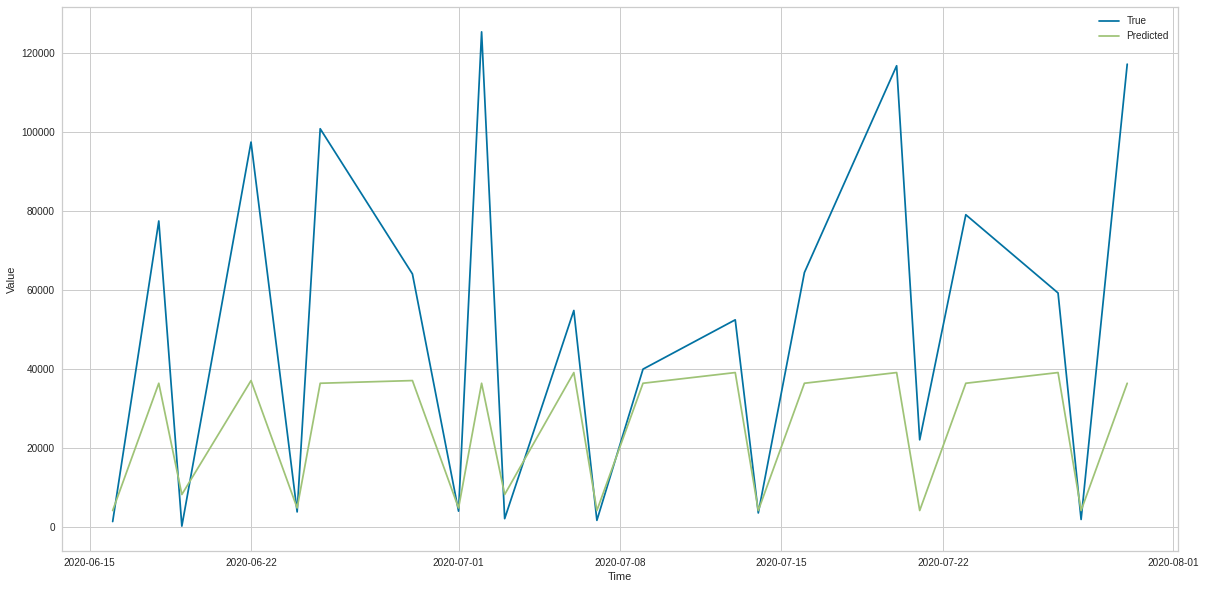

In [ ]:
plt.figure(figsize=(20,10))
plot_series(test.index, test['sale_dollars'],"True")
#plot_series(train['ds'],train['y'])
plot_series(test.index, unseen_predictions['Label'],"Predicted")

In [ ]:
huber = create_model('huber', verbose = False)
rf = create_model('rf', verbose = False)
lightgbm = create_model('lightgbm', verbose = False)
ridge = create_model('ridge', verbose = False)

In [ ]:
tuned_rf = tune_model(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,15259.7086,596998904.6272,24433.5610,0.8312,1.4823,8.4080
1,20477.6624,803706465.4753,28349.7172,0.6890,0.8868,0.9551
2,23799.5493,1345691475.6769,36683.6677,0.5753,1.7107,19.9766
3,18039.8859,665230499.8780,25792.0627,0.7523,0.9662,2.0402
4,15153.7323,452966362.3656,21283.0064,0.8298,2.5526,19.2854
5,21810.4485,1209317958.9684,34775.2492,0.6490,1.4488,6.1173
6,33326.5873,2019250547.1228,44936.0718,0.2180,1.1088,1.7301
7,21624.4747,1298625946.5390,36036.4530,0.5330,1.5573,10.5617
8,17265.9871,623816786.8198,24976.3245,0.7727,1.2222,2.9051
9,22795.7105,1146187701.1780,33855.3940,0.6352,1.4046,3.4733


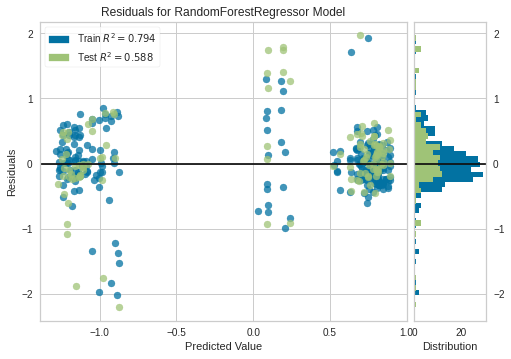

In [ ]:
plot_model(tuned_rf)

In [ ]:
xgb=create_model('xgboost')
tuned_xbb= tune_model(xgb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,20137.1088,889337046.0406,29821.7546,0.7485,1.1822,2.9356
1,26041.2203,1447059664.4617,38040.2374,0.4401,1.1008,0.9229
2,25072.7567,1512294609.5135,38888.2323,0.5227,1.5802,6.9897
3,22372.8952,1198801078.7726,34623.7069,0.5537,1.0393,2.1411
4,14606.7473,491695007.4796,22174.1969,0.8152,2.4740,15.3445
5,22480.3557,1326474339.3210,36420.7954,0.6150,1.3386,3.9068
6,31628.0057,2074654955.6070,45548.3804,0.1966,1.1654,1.9177
7,21825.6322,1305185110.4125,36127.3457,0.5307,1.5182,10.4337
8,18863.4928,692247660.6431,26310.5998,0.7478,1.1807,2.4165
9,21532.5577,1010728976.7981,31791.9640,0.6783,1.4661,2.7545


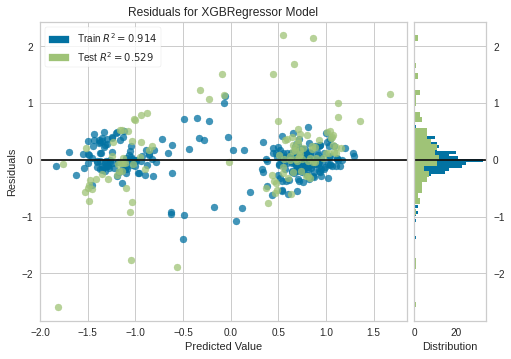

In [ ]:
plot_model(tuned_xbb)

In [ ]:
blend_specific = blend_models(estimator_list = [tuned_rf,tuned_lightgbm,tuned_xbb])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,15689.4246,585172956.8565,24190.3484,0.8345,1.3502,5.3085
1,21694.6983,949211165.7534,30809.2708,0.6327,0.8838,0.9082
2,23540.1970,1322598539.3594,36367.5479,0.5826,1.6451,18.2100
3,18369.7914,714930562.4877,26738.1855,0.7338,0.9597,2.0672
4,14098.4128,435344451.5223,20864.9096,0.8364,2.5362,19.1641
5,21408.7555,1281419991.7455,35796.9271,0.6281,1.4040,5.3350
6,32825.3732,1978279173.1285,44477.8504,0.2339,1.0754,1.7616
7,20383.8812,1240654985.7608,35222.9327,0.5539,1.5466,11.3408
8,17103.9530,571294740.3417,23901.7727,0.7918,1.1548,2.7105
9,21989.0859,1130405729.8528,33621.5070,0.6402,1.4271,3.6860


In [ ]:
predict_model(blend_specific);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,22317.8984,1.213626e+09,34837.1388,0.5323,1.6162,0 8.648864 dtype: float64


In [ ]:
final_model = finalize_model(blend_specific)

In [ ]:
unseen_predictions_2 = predict_model(final_model, data=test, round=0)
unseen_predictions_2.loc[unseen_predictions_2['Label'] < 0, 'Label'] = 0
unseen_predictions_2.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,flag,sale_dollars,Label
0,1,2,6,2020,168,16,25,1,1376.22,3810.0
1,3,2,6,2020,170,18,25,1,77424.58,40470.0
2,4,2,6,2020,171,19,25,1,226.68,5538.0
3,0,2,6,2020,174,22,26,1,97385.87,43713.0
4,2,2,6,2020,176,24,26,1,3810.90,6688.0


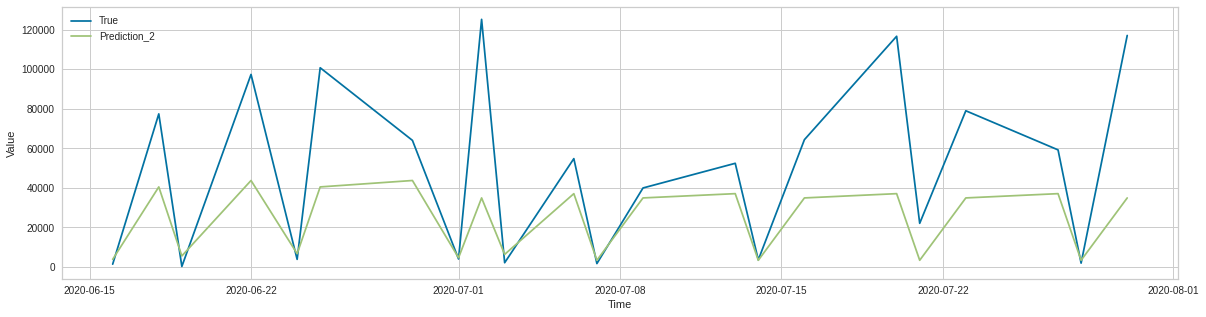

In [ ]:
plt.figure(figsize=(20,5))
plot_series(test.index, test['sale_dollars'],"True")
#plot_series(train['ds'],train['y'])
#plot_series(X_test.index, unseen_predictions['Label'],'Prediction_1')
plot_series(test.index, unseen_predictions_2['Label'],'Prediction_2')


In [ ]:
stack_1 = stack_models([tuned_rf,tuned_xbb, tuned_lightgbm])
predict_model(stack_1);
final_stack_1 = finalize_model(stack_1)
unseen_predictions_3 = predict_model(final_stack_1, data=test, round=0)


In [ ]:
def calc_smape(y_hat, y):
        return 100/len(y) * np.sum(2 * np.abs(y_hat - y) / (np.abs(y) + np.abs(y_hat)))

In [ ]:
calc_smape(test['sale_dollars'].values,unseen_predictions['Label'].values)

74.01474475766958

In [ ]:
calc_smape(test['sale_dollars'].values,unseen_predictions_2['Label'].values)

71.70005192174423

In [ ]:
calc_smape(test['sale_dollars'].values,unseen_predictions_3['Label'].values)

127.51149117271584